<Axes: title={'center': 'Monthly Index Over Time'}, xlabel='Date'>

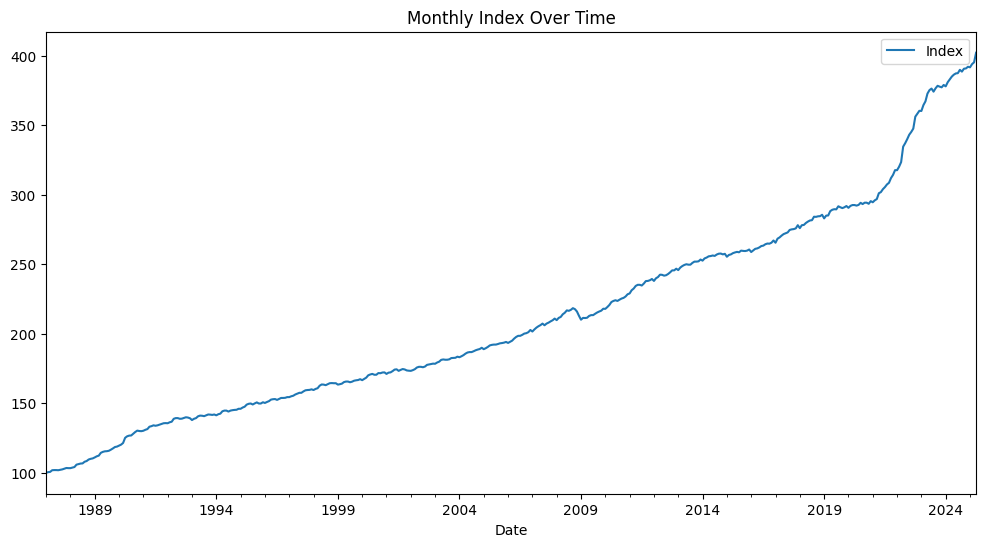

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# Load the raw file
with open("data/series-080625.csv", "r", encoding="utf-8") as file:
    raw_text = file.read()

# Use regex to extract only monthly entries in the form "YYYY MMM","value"
pattern = re.compile(r'"(\d{4}) (\b[A-Z]{3})","([\d.]+)"')

# Month abbreviation to number
month_map = {
    "JAN": 1, "FEB": 2, "MAR": 3, "APR": 4, "MAY": 5, "JUN": 6,
    "JUL": 7, "AUG": 8, "SEP": 9, "OCT": 10, "NOV": 11, "DEC": 12
}

# Extract data
data = []
for match in pattern.finditer(raw_text):
    year, month_abbr, value = match.groups()
    date = pd.Timestamp(int(year), month_map[month_abbr], 1)
    data.append((date, float(value)))

# Create a DataFrame
df_monthly = pd.DataFrame(data, columns=["Date", "Index"]).set_index("Date").sort_index()

df_monthly.plot(title="Monthly Index Over Time", figsize=(12, 6))

<Axes: title={'center': 'Year-on-Year Inflation Rate'}, xlabel='Date', ylabel='Inflation Rate (%)'>

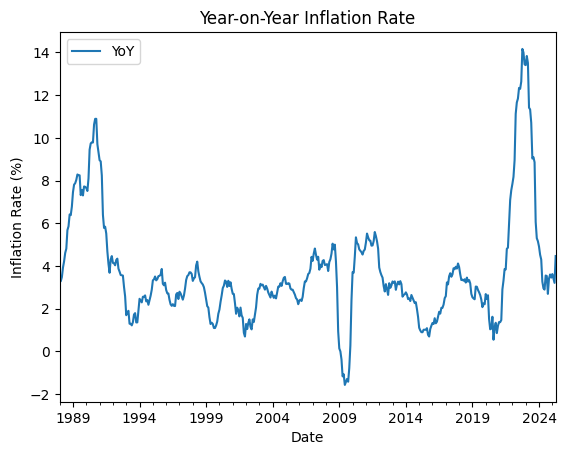

In [2]:
# Define a function to compute YoY inflation rates
def compute_yoy_inflation(index_df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute year-on-year percentage change from a monthly index DataFrame.

    Parameters:
        index_df (pd.DataFrame): DataFrame with datetime index and a column named 'Value'

    Returns:
        pd.DataFrame: DataFrame with 'YoY' column showing YoY percentage change
    """
    yoy = index_df["Index"].pct_change(periods=12) * 100
    return pd.DataFrame({"YoY": yoy}).dropna()

# Apply the function to get YoY inflation
df_yoy = compute_yoy_inflation(df_monthly)

df_yoy.plot(title="Year-on-Year Inflation Rate", ylabel="Inflation Rate (%)")


In [3]:
def rpi_last_12y_matrix(index_df: pd.DataFrame, output_path: str = "data/rpi_last_10y1m_matrix.csv") -> pd.DataFrame:
    """
    Extracts the RPI index for the last 10 years plus 1 month, arranges it in a DataFrame
    with months as rows and years as columns, and saves it as a CSV.

    Parameters:
        index_df (pd.DataFrame): DataFrame with datetime index and 'Index' column.
        output_path (str): Path to save the resulting CSV.

    Returns:
        pd.DataFrame: The pivoted DataFrame.
    """
    # Determine the last date in the index
    last_date = index_df.index.max()
    # Calculate the start date (10 years and 1 month before last_date)
    start_date = last_date - pd.DateOffset(years=12, months=1)
    # Filter the DataFrame
    df_filtered = index_df.loc[start_date:last_date].copy()
    # Add year and month columns
    df_filtered['Year'] = df_filtered.index.year
    df_filtered['Month'] = df_filtered.index.month
    # Pivot: rows=Month, columns=Year, values=Index
    matrix = df_filtered.pivot(index='Month', columns='Year', values='Index')
    # Save to CSV
    matrix.to_csv(output_path)
    return matrix

# Example usage:
rpi_matrix = rpi_last_12y_matrix(df_monthly)

In [4]:
def multiplicative_seasonality(index_df: pd.DataFrame, start: str = None, end: str = None) -> pd.Series:
    """
    Calculate the multiplicative seasonality vector for a given date range.
    Returns a Series indexed by month (1-12), normalized so the geometric mean is 1.
    By default, uses the last 10 years of data.
    """
    if end is None:
        end = index_df.index.max()
    else:
        end = pd.to_datetime(end)
    if start is None:
        start = end - pd.DateOffset(years=10)
    df = index_df.loc[start:end]
    monthly_avg = df.groupby(df.index.month)["Index"].mean()
    geom_mean = np.exp(np.log(monthly_avg).mean())
    seasonality_vector = monthly_avg / geom_mean
    return seasonality_vector

In [54]:
import pandas as pd
import numpy as np

def calculate_multiplicative_seasonality(index_df: pd.DataFrame, anchor_month: int = 12, years_data: int = 10):
    index_df = index_df.copy()
    index_df.index = pd.to_datetime(index_df.index)
    index_df = index_df.sort_index()

    today = pd.Timestamp.today()
    last_anchor_year = today.year if today.month > anchor_month else today.year - 1
    last_anchor_date = pd.Timestamp(last_anchor_year, anchor_month, 1)
    first_anchor_date = pd.Timestamp(last_anchor_year - years_data, anchor_month, 1)

    df = index_df.loc[first_anchor_date:last_anchor_date]

    anchor_dates = pd.date_range(start=first_anchor_date, end=last_anchor_date, freq="12MS")
    anchor_index = df.reindex(anchor_dates)["Index"].dropna()

    monthly_expected = []
    actual_index = []
    month_labels = []

    # Explicity include the first anchor point
    first_date = anchor_index.index[0]
    first_value = anchor_index.iloc[0]
    if first_date in df.index:
        monthly_expected.append(first_value)
        actual_index.append(df.loc[first_date, "Index"])
        month_labels.append(first_date)

    # Calculate expected values for each month based on the growth between anchor points
    for i in range(1, len(anchor_index)):
        start_date = anchor_index.index[i - 1]
        end_date = anchor_index.index[i]
        start_value = anchor_index.iloc[i - 1]
        end_value = anchor_index.iloc[i]
        growth = np.log(end_value / start_value)

        for month_offset in range(1, 13):
            date = start_date + pd.DateOffset(months=month_offset)
            if date not in df.index:
                continue
            expected = start_value * np.exp((month_offset / 12) * growth)
            actual = df.loc[date, "Index"]
            monthly_expected.append(expected)
            actual_index.append(actual)
            month_labels.append(date)

    monthly_df = pd.DataFrame({
        "Expected Index": monthly_expected,
        "Actual Index": actual_index
    }, index=pd.to_datetime(month_labels))

    monthly_df["S = Actual / Expected"] = monthly_df["Actual Index"] / monthly_df["Expected Index"]
    monthly_df["M = S / S_last"] = monthly_df["S = Actual / Expected"] / monthly_df["S = Actual / Expected"].shift(1)

    # Step 6: Build 12-month month-on-month seasonality ratios per year
    seasonality_vectors = []
    labels = []

    for i in range(1, len(anchor_index)):
        start_date = anchor_index.index[i - 1]
        end_date = start_date + pd.DateOffset(months=12)
        slice_df = monthly_df.loc[start_date:end_date, "M = S / S_last"]
        slice_df = slice_df[1:]

        if len(slice_df) < 12:
            continue

        m_values = slice_df.values
        seasonality_vectors.append(m_values)
        labels.append(end_date.year)

    # Build DataFrame and relabel columns
    months = [(anchor_month + i) % 12 + 1 for i in range(12)]
    month_names = [pd.Timestamp(2000, m, 1).strftime("%b") for m in months]
    seasonality_df = pd.DataFrame(seasonality_vectors, index=labels, columns=month_names)

    # Mean seasonality vector (month-on-month ratios)
    seasonality_vector = seasonality_df.mean()

    # Optional: log trend
    annual_log_trend = np.log(anchor_index / anchor_index.iloc[0])

    return monthly_df, seasonality_vector, annual_log_trend, seasonality_df



monthly_df, seasonality_vector, annual_log_trend, seasonality_df = calculate_multiplicative_seasonality(df_monthly, anchor_month=12, years_data=10)
display(monthly_df.tail(25))  # Display first 12 rows of the monthly DataFrame
display(seasonality_df.T.tail(25))  # Display first 12 rows of the monthly DataFrame
display(seasonality_vector)  # Display the seasonality vector

,Expected Index,Actual Index,S = Actual / Expected,M = S / S_last
2022-12-01,360.400000,360.4,1.000000,0.995346
2023-01-01,361.914501,360.3,0.995539,0.995539
2023-02-01,363.435366,364.5,1.002929,1.007423
2023-03-01,364.962623,367.2,1.006130,1.003192
2023-04-01,366.496297,372.8,1.017200,1.011002
2023-05-01,368.036417,375.3,1.019736,1.002493
2023-06-01,369.583008,376.4,1.018445,0.998734
2023-07-01,371.136099,374.2,1.008255,0.989995
2023-08-01,372.695716,376.6,1.010476,1.002202
2023-09-01,374.261887,378.4,1.011057,1.000575


,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
Jan,0.990856,0.991056,0.990672,0.990250,0.989096,0.994558,0.991262,0.989546,0.995539,0.994541
Feb,1.004088,1.002576,1.007529,1.005377,1.005238,1.003820,0.998677,0.997333,1.007423,1.005086
Mar,1.000560,1.002171,0.999984,0.998502,0.998534,1.001060,0.996976,0.999744,1.003192,1.002407
Apr,1.002500,0.999096,1.001454,1.002804,1.009037,0.999007,1.008014,1.023500,1.011002,1.002379
May,1.000939,1.000621,1.000694,1.001352,1.001647,0.997642,0.996594,0.996940,1.002493,1.000798
Jun,1.000549,1.001757,0.998843,1.000629,0.999564,1.000717,1.000867,0.998059,0.998734,0.999495
Jul,0.997846,0.999087,0.998839,0.998494,0.997839,1.004127,0.998858,0.998859,0.989995,0.997687
Aug,1.003639,1.001738,1.003216,1.006640,1.005769,0.995951,1.000135,0.995313,1.002202,1.003348
Sep,0.998234,0.999836,0.998094,0.997434,0.995788,1.002413,0.997834,0.996426,1.000575,0.993848
Oct,0.998618,0.997572,0.997367,0.999190,0.996125,0.999007,1.004904,1.014029,0.994236,1.002561


Jan    0.991738
Feb    1.003715
Mar    1.000313
Apr    1.005879
May    0.999972
Jun    0.999921
Jul    0.998163
Aug    1.001795
Sep    0.998048
Oct    1.000361
Nov    0.998271
Dec    1.001962
dtype: float64

['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


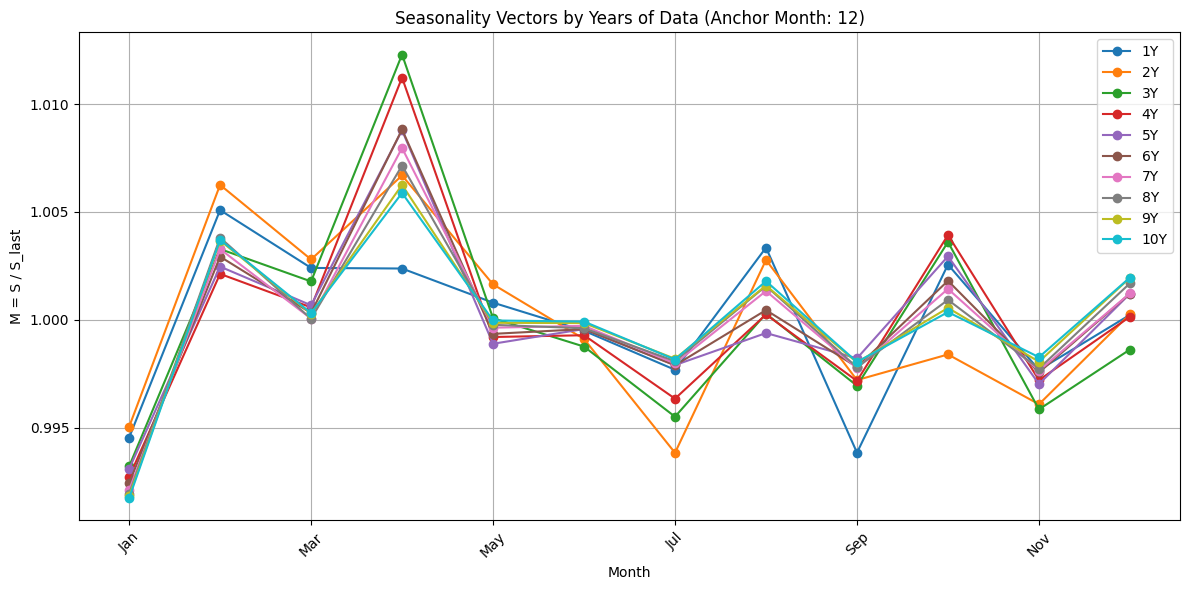

In [62]:
import matplotlib.pyplot as plt

def seasonality_vectors_over_years(index_df: pd.DataFrame, anchor_month: int = 12, max_years: int = 10):
    all_vectors = {}
    
    for years in range(1, max_years + 1):
        _, vector, _, _ = calculate_multiplicative_seasonality(index_df, anchor_month=anchor_month, years_data=years)
        all_vectors[f"{years}Y"] = vector.values

    # Combine into DataFrame
    months = [(anchor_month + i) % 12 + 1 for i in range(12)]
    month_names = [pd.Timestamp(2000, m, 1).strftime("%b") for m in months]
    print(month_names)
    df_all = pd.DataFrame(all_vectors, index=month_names)

    # Plotting
    ax = df_all.plot(figsize=(12, 6), marker='o', title=f"Seasonality Vectors by Years of Data (Anchor Month: {anchor_month})")
    ax.set_ylabel("M = S / S_last")
    ax.set_xlabel("Month")
    ax.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return df_all

df_result = seasonality_vectors_over_years(df_monthly, anchor_month=12, max_years=10)


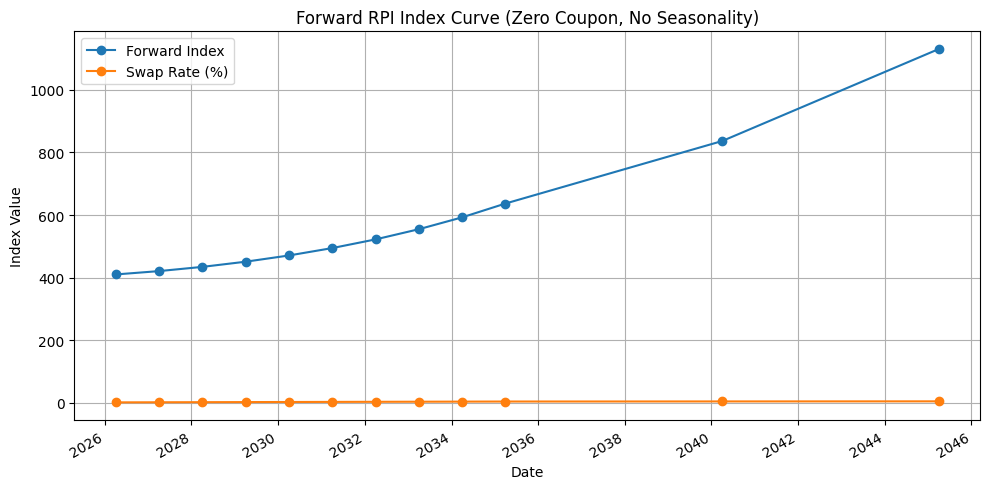

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Use the existing df_monthly and rename column if necessary
df_monthly = df_monthly.rename(columns={"Value": "Index"})

# Define 'today' explicitly
today = pd.Timestamp.today()

# Create a hypothetical swap curve from 2% to 5% over 10 years
pillars = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
swap_curve = pd.Series(
    [2 + 3 * (y - 1) / 10 for y in range(1, len(pillars) + 1)],
    index=pillars,
    name="Hypothetical Swap Rate (%)"
)

# Deduce the base month (lagged from today)
lag_months = 2
base_month = pd.Timestamp(today.year, today.month, 1) - pd.DateOffset(months=lag_months)
base_month = pd.Timestamp(base_month.year, base_month.month, 1)  # Ensure 1st of the month

# Use a fallback if base_month is not in df
if base_month not in df_monthly.index:
    base_month = df_monthly.index[df_monthly.index.get_loc(base_month, method='pad')]

base_index = df_monthly.loc[base_month, "Index"]

# Calculate forward indices
forward_indices = []
for tenor in pillars:
    swap_rate = swap_curve.loc[tenor] / 100
    forward_index = base_index * (1 + swap_rate) ** tenor
    forward_indices.append(forward_index)

# Build the DataFrame with all dates pinned to the 1st of the month
forward_index_curve = pd.DataFrame({
    "Date": [pd.Timestamp(base_month.year + tenor, base_month.month, 1) for tenor in pillars],
    "Forward Index": forward_indices,
    "Swap Rate (%)": swap_curve.values
}).set_index("Date")

# Plot
ax = forward_index_curve.plot(title="Forward RPI Index Curve (Zero Coupon, No Seasonality)",
                              ylabel="Index Value", figsize=(10, 5), marker='o')
ax.grid(True)
plt.tight_layout()
plt.show()
